# TensorFlow Data Pipeline, Mini DenseNet and GradCAM - Part 1

## Bölümler

#### 1.part
* Veri Yükleme
 * `tf.data.Dataset.list_files()` kullanarak.
 
 
* Ön İşleme ve Resimleri Augment Etme
 * `tf.data` pipeline'ı oluşturup `tf.image` ve `tfa.image` kullanarak.


#### 2.part
* Modeli Oluşturmak
 * Mini DenseNet ve Layer Subclassing kullanmak
 * Modeli custom training loop kullanarak eğitmek


* Loss ve Accuracy Eğrilerini Plot Etmek
 * Training loop kullanarak toplanan loss ve accuracy değerlerini plot edip görmek


* Gradient-weighted Class Activation Mapping (GradCAM)
 * Neden GradCAM'e ihtiyaç duyarız?
 * GradCAM Nedir?
 * GradCAM'i test setinde denemek

## Kütüphaneler

In [1]:
import warnings
warnings.filterwarnings('ignore')

import time

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Dense, GlobalMaxPooling2D, Dropout, \
                                    BatchNormalization, Conv2D, \
                                    MaxPooling2D, Concatenate, AveragePooling2D

import matplotlib.pyplot as plt

import os
import numpy as np

import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report

import PIL
import glob
import pathlib

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
        print(e)

print('TF Version:', tf.__version__)
print('TFA Version:', tfa.__version__)

1 Physical GPUs, 1 Logical GPUs
TF Version: 2.7.0-dev20210904
TFA Version: 0.14.0


## Veri Yükleme

In [2]:
# Train ve Test klasörlerinin sırasıyla isimleri.
train_dir = "seg_train"
test_dir = "seg_test"

In [3]:
# Her ana klasör kendi için alt sınıf klasörlerine ayrıldığı için
# iki kere /* ekliyoruz. Böylece tüm resimleri almış olacağız.
train_dir_list = train_dir + '/*/*'
test_dir_list = test_dir + '/*/*'
train_dir_list, test_dir_list

('seg_train/*/*', 'seg_test/*/*')

In [4]:
# Dataset boyutunu direkt olarak görebilmek için
# bir fonksiyon yazıyoruz.
def data_size(ds):
    return tf.data.experimental.cardinality(ds).numpy()

In [5]:
# list_files bir tf.data olup, glob patterni eşleşen tüm dosyaları alacaktır.
list_ds_train = tf.data.Dataset.list_files(train_dir_list, 
                                     shuffle = False)

list_ds_test = tf.data.Dataset.list_files(test_dir_list, 
                                     shuffle = False)

list_ds_train = list_ds_train.shuffle(data_size(list_ds_train),
                                     reshuffle_each_iteration = False)

list_ds_test = list_ds_test.shuffle(data_size(list_ds_test),
                                     reshuffle_each_iteration = False)

# Datasetlerden birer tane örnek al.
for files in list_ds_train.take(1):
    print(files.numpy().decode('utf-8'))
    # seg_train\mountain\2174.jpg

for files in list_ds_test.take(1):
    print(files.numpy().decode('utf-8'))
    # seg_test\mountain\24204.jpg
    
# Datasetlerin boyutuna bak.
total_images = data_size(list_ds_train)
print('\nEğitim setinde %d resim var' %(total_images)) # 14034 

total_test = data_size(list_ds_test)
print('\nTest setinde %d resim var' %(total_test)) # 3000

seg_train\mountain\11355.jpg
seg_test\buildings\21763.jpg

Eğitim setinde 14034 resim var

Test setinde 3000 resim var


In [6]:
# Sınıf isimlerini dizinden almak için pathlib kullanıyoruz.
data_dir = pathlib.Path(train_dir)

class_names = [files.name for files in data_dir.glob('*/')]

# Alfabetik olarak sırala.
class_names = np.array(sorted(class_names), dtype = 'object')

print(class_names) # ['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [7]:
# Train datasından validation set oluşturmak için
# take() ve skip() fonksiyonlarını kullanabiliriz.
val_size = int(total_images * 0.1)

list_ds_val = list_ds_train.take(val_size)
list_ds_train = list_ds_train.skip(val_size)

print('Train:', data_size(list_ds_train)) # 12631
print('Val:', data_size(list_ds_val)) # 1403
print('Test:', data_size(list_ds_test)) # 3000

# Overlap var mı diye kontrol et.
train = []
for x in list_ds_train:
    train.append(x.numpy().decode('utf-8'))

val = []
for x in list_ds_val:
    val.append(x.numpy().decode('utf-8'))
    
len(set(train).intersection(set(val))) # 0

Train: 12631
Val: 1403
Test: 3000


In [9]:
def get_label(files_path):
    # contents tensor içeriği:
    # <tf.Tensor: shape=(6,), dtype=string, numpy=
    # array([... b'seg_train', # Son iki string sınıfı ve resmin ismini içeriyor.
    #        b'glacier', b'10.jpg'], dtype=object)>

    contents = tf.strings.split(files_path, os.path.sep)
       
    # class_idx tensor içeriği:
    # <tf.Tensor: shape=(6,), dtype=bool, numpy=array([False, False, 
                                        # True, False, False, False])>
    class_idx = contents[-2] == class_names
  
    # Return: tf.where(class_idx)
    # <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[2]])>
    # Alternatif olarak tf.argmax(class_idx) kullanabilirdik
    return tf.where(class_idx)[0][0]

def decode_img(image):
    # tf.io.read_file ile okunmuş resimlerin tf.image.decode_jpeg
    # ile decode edilmesi gerekir. Bu sayede resimleri array formatına
    # çevirmiş oluruz. channel=3 diyerek de RGB olduğunu belirtiyoruz.
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def process_path(file_path):
    label = get_label(file_path)
  
    # img :<tf.Tensor: shape=(), dtype=string, numpy=b'\xff\xd8\xff\x0\ ...
    # tf.io.read_file içeriği olduğu gibi okur, onun için decode edilmesi gerekir.
    image = tf.io.read_file(file_path)

    # Şimdi ise resimler artık array formatındadır.
    image = decode_img(image)
    return image, label

In [10]:
# num_parallel_calls ile mapping işlemini parallelize etmiş oluyoruz.
# tf.data.AUTOTUNE, tf.data çalışma zamanı sırasında paralellik düzeyine karar verecektir.

train_ds = list_ds_train.map(process_path, 
                             num_parallel_calls=tf.data.AUTOTUNE)

val_ds = list_ds_val.map(process_path, 
                         num_parallel_calls=tf.data.AUTOTUNE)

test_ds = list_ds_test.map(process_path, 
                           num_parallel_calls=tf.data.AUTOTUNE)

## Ön İşleme ve Augment Etmek

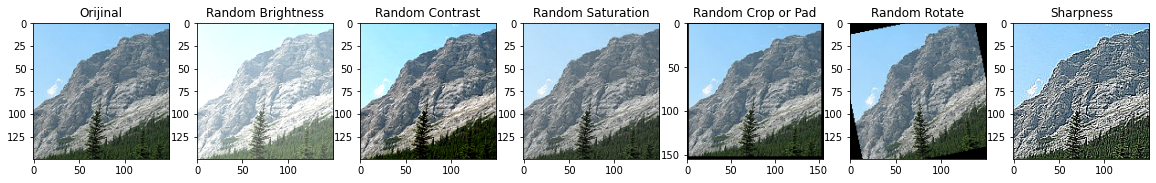

In [11]:
# tf.image ve tfa.image ile resimleri augment edebilir veya üzerlerinde random
# dönüşümler uygulayabiliriz.

for x, y in train_ds.take(1): # Datasetten 1 tane resim ve label çifti alır.
    seed = (52, 2)
    
    # Burada tf.image ve tfa.image altında olan fonksiyonları göstereceğim.
    # Random dönüşümler için stateless_random_* olanları kullanıyoruz.
    # Farkını aşağıda açıklıyorum.
    
    random_bright = tf.image.stateless_random_brightness(x, max_delta=1.0, 
                                                       seed = seed)

    random_contrast = tf.image.stateless_random_contrast(x, 0.2, 2.0,
                                                       seed = seed)

    random_saturation = tf.image.stateless_random_saturation(x, 0.2, 1.0,
                                                           seed = seed)

    random_crop_or_pad = tf.image.resize_with_crop_or_pad(x, 
                               tf.shape(x).numpy()[0] + 5, 
                               tf.shape(x).numpy()[1] + 5)

    random_rotate = tfa.image.rotate(x, tf.constant(tf.random.uniform((1,), 
                                                        minval = 0.01,
                                                        maxval = 0.4)))

    sharpness = tfa.image.sharpness(x, 5.1)

    plt.figure(figsize = (20, 12))

    plt.subplot(1, 7, 1)
    plt.imshow(x.numpy() / 255.0)
    plt.title('Orijinal')

    plt.subplot(1, 7, 2)
    plt.imshow(random_bright.numpy() / 255.0)
    plt.title('Random Brightness')

    plt.subplot(1, 7, 3)
    plt.imshow(random_contrast.numpy() / 255.0)
    plt.title('Random Contrast')

    plt.subplot(1, 7, 4)
    plt.imshow(random_saturation.numpy() / 255.0)
    plt.title('Random Saturation')

    plt.subplot(1, 7, 5)
    plt.imshow(random_crop_or_pad.numpy() / 255.0)
    plt.title('Random Crop or Pad')

    plt.subplot(1, 7, 6)
    plt.imshow(random_rotate.numpy() / 255.0)
    plt.title('Random Rotate')

    plt.subplot(1, 7, 7)
    plt.imshow(sharpness.numpy() / 255.0)
    plt.title('Sharpness')

In [12]:
def resize_and_one_hot(image, label):
    # Resimleri float32'ye cast ediyoruz.
    image = tf.cast(image, tf.float32)
    
    # Resimlerin hepsini 128 x 128 boyutuna getiriyoruz.
    image = tf.image.resize(image, [128, 128])
    
    # Resimleri normalize edip, labelları one hot encoded şeklinde
    # döndürüyoruz.
    return image / 255.0, tf.one_hot(label, 6)

#### Normal tf.image.random ve tf.stateless_random operasyonları arasındaki fark:
* TensorFlow'da random resim transformasyonları için fonksiyonlar genel olarak iki gruba ayrılır.
  * tf.image.random.* ve
  * tf.image.stateless_random.*


* `tf.image.random` operasyonlarının kullanılması tavsiye edilmez çünkü arka planda TF 1.X'den kalan bazı fonksiyonları kullanırlar. Onun yerine `tf.image.stateless_random` fonksiyonlarını kullanacağız. 

In [13]:
def augment(image_label, seed):
    image, label = image_label
    image, label = resize_and_one_hot(image,label)

    # Dönüşümleri iki gruba ayıracağız.
    transformation_selection = tf.random.uniform([], minval = 0, 
                                                 maxval = 1, 
                                                 dtype = tf.float32)
    
    # İki grubu kendi içinde alt gruplara böleceğiz.
    
    # 1.gruptaki dönüşümleri uygulama ihtimali  
    prob_1 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)
    
    # 2.gruptaki dönüşümleri uygulama ihtimali        
    prob_2 = tf.random.uniform([], minval = 0, maxval = 1, dtype = tf.float32)
    
    # Yani her dönüşümün uygulanmak için %25 şansı var.
    # Her resme sadece bir dönüşüm uygulayacağız.
    image = tf.cond(tf.greater(transformation_selection, 0.5),

                    # tf.cond fonksiyonlarının -callable- olmasını istediği
                    # için lambda yazıyoruz.
                    
                    # Eğer ki transformation_selection > 0.5 ise buraya gelecek.
                    # Eğer prob_1 > 0.5 kontrastı değiştir. Değilse parlaklığı değiştir.
                    lambda: tf.cond(tf.greater(prob_1, 0.5),
                            lambda: tf.image.stateless_random_contrast(image, 0.1, 0.5,
                                                     seed = seed), 
                            lambda: tf.image.stateless_random_brightness(image, max_delta=0.3, 
                                                     seed = seed),
                           ),
                    
                    # Eğer ki transformation_selection < 0.5 ise buraya gelecek.
                    # Eğer prob_2 > 0.5 saturation uygula. Değilse resmi random döndür.
                    lambda: tf.cond(tf.greater(prob_2, 0.5),
                            lambda: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                                           seed = seed),
                            lambda: tfa.image.rotate(image, tf.random.uniform((1,), 
                                                        minval = 0.01,
                                                        maxval = 0.2))                          
                          )     
                   )

    #   new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    #   Eğer ki tf.cond dışında farklı seed kullanıp farklı dönüşümler uygulamak isterseniz
    #   new_seed'i aşağıdaki gibi fonksiyona geçebilirsiniz.
    """
    Örnek: tf.image.stateless_random_saturation(image, 0.01, 0.1,
                                              seed = new_seed)
    """
    return image, label

In [14]:
random_number = tf.random.Generator.from_seed(52222, alg='philox')

# Ana fonksiyonumuz seed alacağı için, bunu başka bir fonksiyonun içine
# koyup, ana fonksiyonumuzu çağırabiliriz. 
def augment_wrapper(x, y):
    seed = random_number.make_seeds(2)[0]
    image, label = augment((x, y), seed)
    return image, label

In [15]:
# Shuffle ve Prefetch'i aşağıda açıklıyorum.

train_ds = (
    train_ds
    .map(augment_wrapper, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

# Validasyon ve Test setlerini augment etmiyoruz.
val_ds = (
    val_ds
    .map(resize_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    test_ds
    .map(resize_and_one_hot, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(32)
    .shuffle(128)
    .prefetch(tf.data.AUTOTUNE)
)

### shuffle() nasıl çalışır?
* Shuffle fonksiyonunu çağırınca buffer_size diye bir parametre veriyoruz. Mesela, datasetimizde 100K element varsa ve size'ı 1000 olarak verirsek, buffer (arabellek) ilk 1000 element ile doldurulacak ve birisi rastgele seçilecek. Bundan sonra ise, tekrar rastgele eleman seçmeden önce bunu 1000 ve ilk elemanla değiştirecek.


### prefetch() nasıl çalışır?
* Prefetch() fonksiyonu model eğitimi ve ön işleme sürecini overlap etmeye yarayan bir fonksiyodundur. Örnek olarak, GPU n. adımdaki gelen resimleri/verileri işleyip hesaplama yaparken, CPU da bir sonraki adımı hazırlıyor olacak.

* Prefetch ile CPU, GPU model eğitimi yaparken boşta durmayacak, sonraki batch'i hazırlıyor olacak. 

--> prefetch() olmadan:
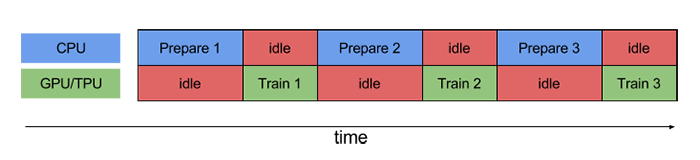

--> prefetch() ile:
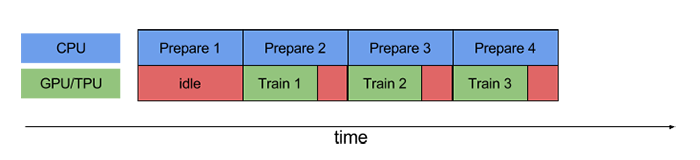

In [16]:
train_ds

<PrefetchDataset shapes: ((None, 128, 128, 3), (None, 6)), types: (tf.float32, tf.float32)>

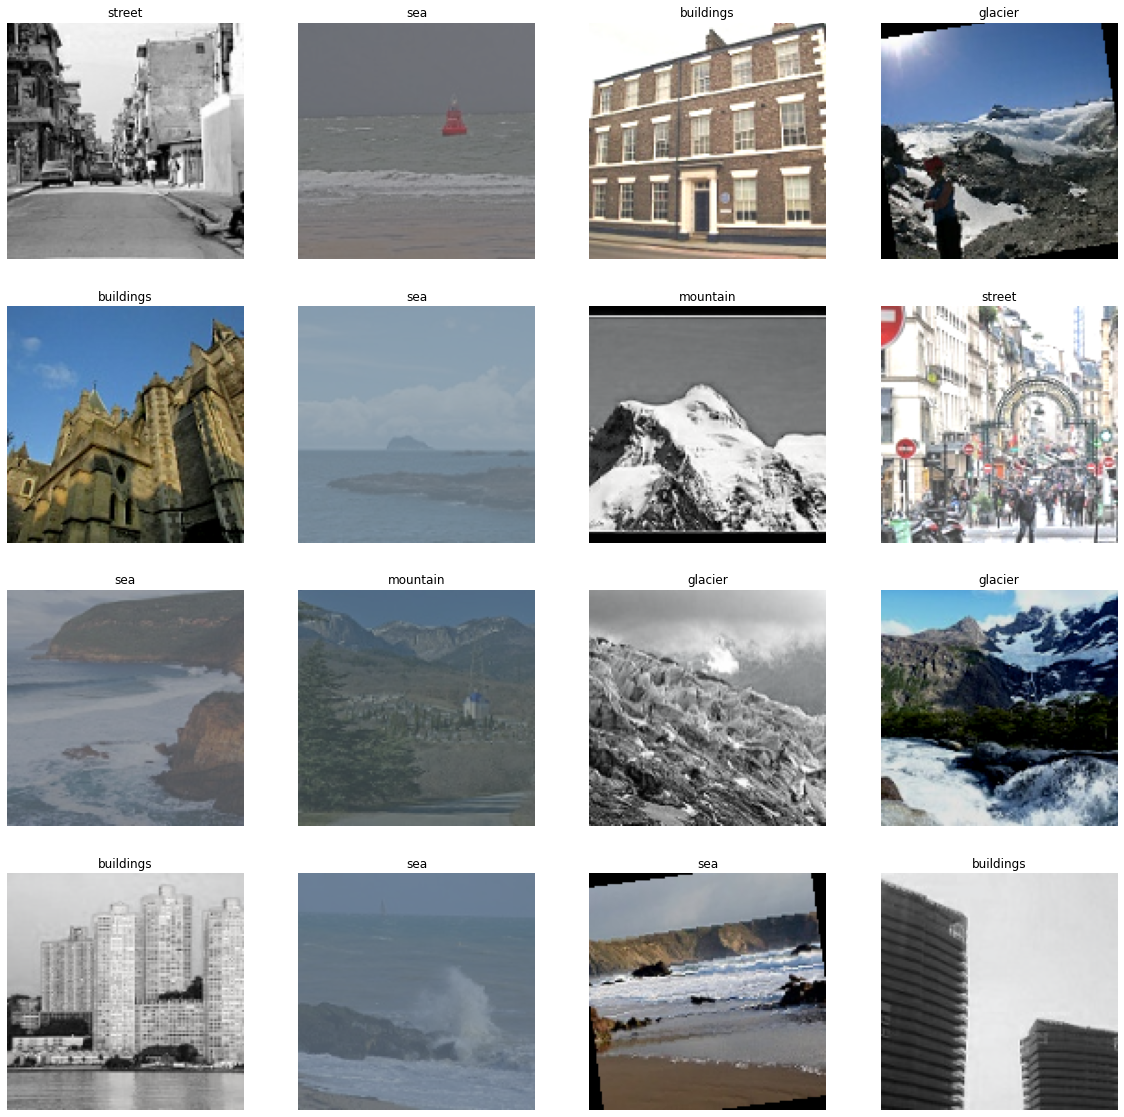

In [17]:
plt.figure(figsize=(20, 20))
plt.tight_layout()

# tf.data datasetimizi batchlediğimizden ötürü take(1) bütün batch'i döndürür.
# Ondan dolayı içeride bir for açıp batch içinde bulunan resimler arasında dönüyoruz.
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(tf.clip_by_value(images[i], 0, 1).numpy())
        plt.title(class_names[tf.argmax(labels[i], axis = -1)])
        plt.axis("off")

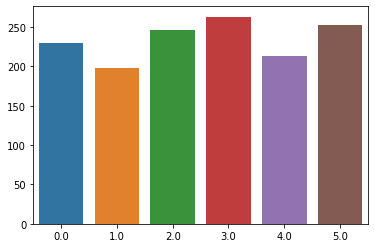

In [18]:
# tf.data.Datasetlerde sınıf label dağılımlarını saymak için daha iyi bir
# yöntem var mı bilmiyorum. Burada basitçe labelları tek tek sayıyoruz.

# Büyük datasetlerde çok iyi bir yöntem olmayabilir.

# Veya batchleri sayıp, sonrasında birleştirebiliriz.

labels, counts = np.unique(np.fromiter(val_ds.unbatch().map(lambda x, y: tf.argmax(y, axis = -1)), np.float32), 
                       return_counts=True)
sns.barplot(labels, counts)
plt.show()

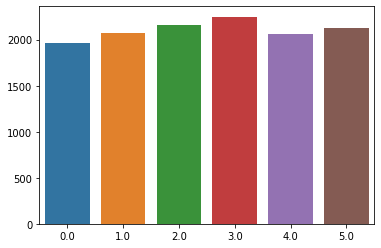

In [19]:
labels, counts = np.unique(np.fromiter(train_ds.unbatch().map(lambda x, y: tf.argmax(y, axis = -1)), np.float32), 
                       return_counts=True)
sns.barplot(labels, counts)
plt.show()